Hello
In this notebook I will extract stocks data via web scraping and pandas datareader from Yahoo finance API. Then make visualization of particular stock as open-high-low-close (OHLC) candlestick chart and use ML to find smth. 

In [1]:
import bs4 as bs # web scraping
import pandas as pd
import pickle  # to save
import requests # to get an information
import datetime as dt
import os # to create directories
import pandas_datareader.data as pdr # reading data from finance API
import yfinance as yf # support for datareader
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
yf.pdr_override() #without this line pandas datareader is not working

Here I import all libraries that would be used in notebook. Most of them are already known for large audience, but I add some comments to clarify why others are used.

In [4]:
def save_sp500_tickers():
    resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    soup = bs.BeautifulSoup(resp.text, 'lxml')
    table = soup.find('table', {'class': 'wikitable sortable'})
    tickers = []
    
    for row in table.findAll('tr')[1:]:
        ticker = row.findAll('td')[0].text.strip().replace('.','-')
        tickers.append(ticker)
        
    with open("sp500tickers.pickle","wb") as f:
        pickle.dump(tickers,f)
        print(tickers)
    
    return tickers

save_sp500_tickers()

I made a function to web scrape and save a list of S&P 500 companies. It is better to save the list of companies rather than reading each time from the Internet. I took wikipedia as a source for the list since it is updated regularly and data saved in the form of table. The list is saved as 'sp500tickers.pickle'. If you want to update list, you could rerun this function.

In [5]:
def get_data_from_yahoo(reload_sp500=False):
    if reload_sp500:
        tickers=save_sp500_tickers()
    else:
        with open("sp500tickers.pickle",'rb') as f:
            tickers=pickle.load(f)
    if not os.path.exists('stock_dfs'):
        os.makedirs('stock_dfs')
    start = dt.datetime(2010, 1, 1)
    end = dt.datetime.now()
    for ticker in tickers: # change to 'for ticker in tickers[:x]' x - number of companies
        print(ticker)
        ticker=ticker.strip()
        if not os.path.exists('stock_dfs/{}.csv'.format(ticker)):
            df = pdr.DataReader(ticker, start, end)
            df.to_csv('stock_dfs/{}.csv'.format(ticker))
        else:
            print('Already have {}'.format(ticker))
get_data_from_yahoo() # it would be running a little bit long, if you choose to load 500 companies

This function is made to load stocks data from Yahoo and save everything as csv file in directory called 'stock_dfs'. I started from 2010 year until today, which is October of 2023. These files contain Date, Open, High, Low, Close, Adjusted Close and Volume.

If you want to see the graph, you could easily plot OHLC in candlestick chart form and Volume graph below it.

[*********************100%%**********************]  1 of 1 completed
                 Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2020-01-02  74.059998  75.150002  73.797501  75.087502  73.249016  135480400
2020-01-03  74.287498  75.144997  74.125000  74.357498  72.536903  146322800
2020-01-06  73.447502  74.989998  73.187500  74.949997  73.114891  118387200
2020-01-07  74.959999  75.224998  74.370003  74.597504  72.771019  108872000
2020-01-08  74.290001  76.110001  74.290001  75.797501  73.941635  132079200


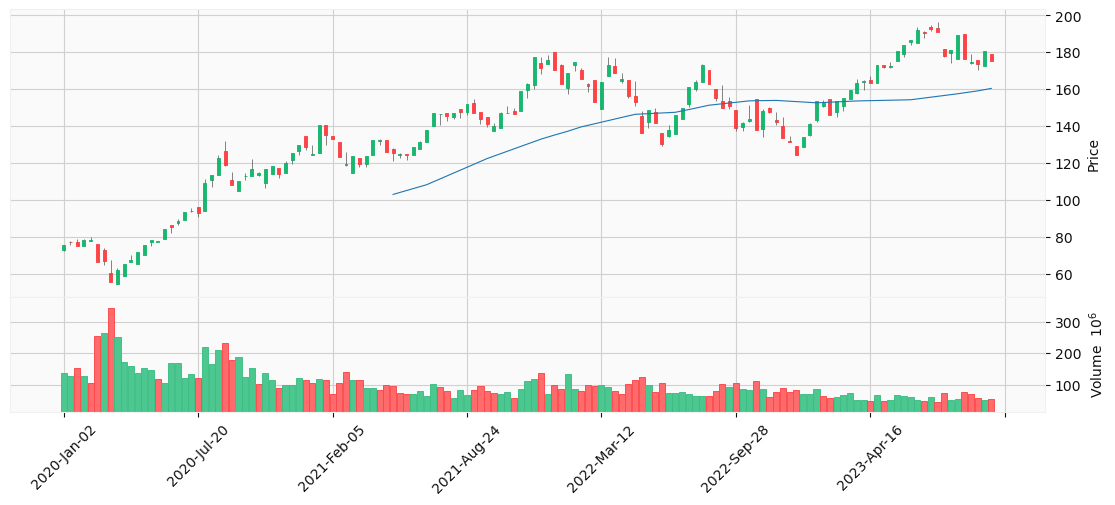

In [6]:
import mplfinance as mpf

start=dt.datetime(2020,1,1)            # choose start date
end=dt.datetime.now()                  # choose end date
df=pdr.DataReader("AAPL", start,end)   # choose company stock
print(df.head())

df_ohlc=df['Adj Close'].resample('10D').ohlc()
df_volume=df['Volume'].resample('10D').mean()
new_df=pd.concat([df_ohlc,df_volume], axis=1)
new_df.rename(columns={'Volume':'volume'}, inplace=True)
mpf.plot(new_df, type='candle', style='yahoo',
        title='',
        figratio=(25,10),
        mav=50,
        volume=True
        )


In [7]:
def compile_data():
    with open('sp500tickers.pickle','rb') as f:
        tickers=pickle.load(f)
    main_df=pd.DataFrame()
    for count, ticker in enumerate(tickers):
        ticker=ticker.strip()
        df=pd.read_csv('stock_dfs/{}.csv'.format(ticker))
        df.set_index('Date', inplace=True)
        df["{}_HL_pct_diff".format(ticker)]=(df['High']-df['Low'])/df['Low']
        df["{}_daily_pct_change".format(ticker)]=(df['Close']-df['Open'])/df['Open']
        df.rename(columns={'Adj Close':ticker}, inplace=True)
        df.drop(['Open','High', 'Low', 'Close', 'Volume'],1,inplace=True)
        if main_df.empty:
            main_df=df
        else:
            main_df=main_df.join(df, how='outer')
        if count%10==0:
            print(count)
    print (main_df.head())
    main_df.to_csv('sp500_joined_closes.csv')
compile_data()

C:\Users\admin\AppData\Local\Temp\ipykernel_19740\4228574515.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(['Open','High', 'Low', 'Close', 'Volume'],1,inplace=True)
C:\Users\admin\AppData\Local\Temp\ipykernel_19740\4228574515.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(['Open','High', 'Low', 'Close', 'Volume'],1,inplace=True)
C:\Users\admin\AppData\Local\Temp\ipykernel_19740\4228574515.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(['Open','High', 'Low', 'Close', 'Volume'],1,inplace=True)
C:\Users\admin\AppData\Local\Temp\ipykernel_19740\4228574515.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-on

0


C:\Users\admin\AppData\Local\Temp\ipykernel_19740\4228574515.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(['Open','High', 'Low', 'Close', 'Volume'],1,inplace=True)
C:\Users\admin\AppData\Local\Temp\ipykernel_19740\4228574515.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(['Open','High', 'Low', 'Close', 'Volume'],1,inplace=True)
C:\Users\admin\AppData\Local\Temp\ipykernel_19740\4228574515.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(['Open','High', 'Low', 'Close', 'Volume'],1,inplace=True)
C:\Users\admin\AppData\Local\Temp\ipykernel_19740\4228574515.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-on

10


C:\Users\admin\AppData\Local\Temp\ipykernel_19740\4228574515.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(['Open','High', 'Low', 'Close', 'Volume'],1,inplace=True)
C:\Users\admin\AppData\Local\Temp\ipykernel_19740\4228574515.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(['Open','High', 'Low', 'Close', 'Volume'],1,inplace=True)
C:\Users\admin\AppData\Local\Temp\ipykernel_19740\4228574515.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(['Open','High', 'Low', 'Close', 'Volume'],1,inplace=True)
C:\Users\admin\AppData\Local\Temp\ipykernel_19740\4228574515.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-on

20


C:\Users\admin\AppData\Local\Temp\ipykernel_19740\4228574515.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(['Open','High', 'Low', 'Close', 'Volume'],1,inplace=True)
C:\Users\admin\AppData\Local\Temp\ipykernel_19740\4228574515.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(['Open','High', 'Low', 'Close', 'Volume'],1,inplace=True)
C:\Users\admin\AppData\Local\Temp\ipykernel_19740\4228574515.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(['Open','High', 'Low', 'Close', 'Volume'],1,inplace=True)
C:\Users\admin\AppData\Local\Temp\ipykernel_19740\4228574515.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-on

30


C:\Users\admin\AppData\Local\Temp\ipykernel_19740\4228574515.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(['Open','High', 'Low', 'Close', 'Volume'],1,inplace=True)
C:\Users\admin\AppData\Local\Temp\ipykernel_19740\4228574515.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(['Open','High', 'Low', 'Close', 'Volume'],1,inplace=True)
C:\Users\admin\AppData\Local\Temp\ipykernel_19740\4228574515.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(['Open','High', 'Low', 'Close', 'Volume'],1,inplace=True)
C:\Users\admin\AppData\Local\Temp\ipykernel_19740\4228574515.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-on

40


C:\Users\admin\AppData\Local\Temp\ipykernel_19740\4228574515.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(['Open','High', 'Low', 'Close', 'Volume'],1,inplace=True)
C:\Users\admin\AppData\Local\Temp\ipykernel_19740\4228574515.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(['Open','High', 'Low', 'Close', 'Volume'],1,inplace=True)
C:\Users\admin\AppData\Local\Temp\ipykernel_19740\4228574515.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(['Open','High', 'Low', 'Close', 'Volume'],1,inplace=True)
C:\Users\admin\AppData\Local\Temp\ipykernel_19740\4228574515.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-on

50


C:\Users\admin\AppData\Local\Temp\ipykernel_19740\4228574515.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(['Open','High', 'Low', 'Close', 'Volume'],1,inplace=True)
C:\Users\admin\AppData\Local\Temp\ipykernel_19740\4228574515.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(['Open','High', 'Low', 'Close', 'Volume'],1,inplace=True)
C:\Users\admin\AppData\Local\Temp\ipykernel_19740\4228574515.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(['Open','High', 'Low', 'Close', 'Volume'],1,inplace=True)
C:\Users\admin\AppData\Local\Temp\ipykernel_19740\4228574515.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-on

60


C:\Users\admin\AppData\Local\Temp\ipykernel_19740\4228574515.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(['Open','High', 'Low', 'Close', 'Volume'],1,inplace=True)
C:\Users\admin\AppData\Local\Temp\ipykernel_19740\4228574515.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(['Open','High', 'Low', 'Close', 'Volume'],1,inplace=True)
C:\Users\admin\AppData\Local\Temp\ipykernel_19740\4228574515.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(['Open','High', 'Low', 'Close', 'Volume'],1,inplace=True)
C:\Users\admin\AppData\Local\Temp\ipykernel_19740\4228574515.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-on

70


C:\Users\admin\AppData\Local\Temp\ipykernel_19740\4228574515.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(['Open','High', 'Low', 'Close', 'Volume'],1,inplace=True)
C:\Users\admin\AppData\Local\Temp\ipykernel_19740\4228574515.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(['Open','High', 'Low', 'Close', 'Volume'],1,inplace=True)
C:\Users\admin\AppData\Local\Temp\ipykernel_19740\4228574515.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(['Open','High', 'Low', 'Close', 'Volume'],1,inplace=True)
C:\Users\admin\AppData\Local\Temp\ipykernel_19740\4228574515.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-on

80


C:\Users\admin\AppData\Local\Temp\ipykernel_19740\4228574515.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(['Open','High', 'Low', 'Close', 'Volume'],1,inplace=True)
C:\Users\admin\AppData\Local\Temp\ipykernel_19740\4228574515.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(['Open','High', 'Low', 'Close', 'Volume'],1,inplace=True)
C:\Users\admin\AppData\Local\Temp\ipykernel_19740\4228574515.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(['Open','High', 'Low', 'Close', 'Volume'],1,inplace=True)
C:\Users\admin\AppData\Local\Temp\ipykernel_19740\4228574515.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-on

90


C:\Users\admin\AppData\Local\Temp\ipykernel_19740\4228574515.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(['Open','High', 'Low', 'Close', 'Volume'],1,inplace=True)
C:\Users\admin\AppData\Local\Temp\ipykernel_19740\4228574515.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(['Open','High', 'Low', 'Close', 'Volume'],1,inplace=True)
C:\Users\admin\AppData\Local\Temp\ipykernel_19740\4228574515.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(['Open','High', 'Low', 'Close', 'Volume'],1,inplace=True)
C:\Users\admin\AppData\Local\Temp\ipykernel_19740\4228574515.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-on

100


C:\Users\admin\AppData\Local\Temp\ipykernel_19740\4228574515.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(['Open','High', 'Low', 'Close', 'Volume'],1,inplace=True)
C:\Users\admin\AppData\Local\Temp\ipykernel_19740\4228574515.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(['Open','High', 'Low', 'Close', 'Volume'],1,inplace=True)
C:\Users\admin\AppData\Local\Temp\ipykernel_19740\4228574515.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(['Open','High', 'Low', 'Close', 'Volume'],1,inplace=True)
C:\Users\admin\AppData\Local\Temp\ipykernel_19740\4228574515.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-on

110


C:\Users\admin\AppData\Local\Temp\ipykernel_19740\4228574515.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(['Open','High', 'Low', 'Close', 'Volume'],1,inplace=True)
C:\Users\admin\AppData\Local\Temp\ipykernel_19740\4228574515.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(['Open','High', 'Low', 'Close', 'Volume'],1,inplace=True)
C:\Users\admin\AppData\Local\Temp\ipykernel_19740\4228574515.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(['Open','High', 'Low', 'Close', 'Volume'],1,inplace=True)
C:\Users\admin\AppData\Local\Temp\ipykernel_19740\4228574515.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-on

120


C:\Users\admin\AppData\Local\Temp\ipykernel_19740\4228574515.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(['Open','High', 'Low', 'Close', 'Volume'],1,inplace=True)
C:\Users\admin\AppData\Local\Temp\ipykernel_19740\4228574515.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(['Open','High', 'Low', 'Close', 'Volume'],1,inplace=True)
C:\Users\admin\AppData\Local\Temp\ipykernel_19740\4228574515.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(['Open','High', 'Low', 'Close', 'Volume'],1,inplace=True)
C:\Users\admin\AppData\Local\Temp\ipykernel_19740\4228574515.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-on

130


C:\Users\admin\AppData\Local\Temp\ipykernel_19740\4228574515.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(['Open','High', 'Low', 'Close', 'Volume'],1,inplace=True)
C:\Users\admin\AppData\Local\Temp\ipykernel_19740\4228574515.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(['Open','High', 'Low', 'Close', 'Volume'],1,inplace=True)
C:\Users\admin\AppData\Local\Temp\ipykernel_19740\4228574515.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(['Open','High', 'Low', 'Close', 'Volume'],1,inplace=True)
C:\Users\admin\AppData\Local\Temp\ipykernel_19740\4228574515.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-on

140


C:\Users\admin\AppData\Local\Temp\ipykernel_19740\4228574515.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(['Open','High', 'Low', 'Close', 'Volume'],1,inplace=True)
C:\Users\admin\AppData\Local\Temp\ipykernel_19740\4228574515.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(['Open','High', 'Low', 'Close', 'Volume'],1,inplace=True)
C:\Users\admin\AppData\Local\Temp\ipykernel_19740\4228574515.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(['Open','High', 'Low', 'Close', 'Volume'],1,inplace=True)
C:\Users\admin\AppData\Local\Temp\ipykernel_19740\4228574515.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-on

150


C:\Users\admin\AppData\Local\Temp\ipykernel_19740\4228574515.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(['Open','High', 'Low', 'Close', 'Volume'],1,inplace=True)
C:\Users\admin\AppData\Local\Temp\ipykernel_19740\4228574515.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(['Open','High', 'Low', 'Close', 'Volume'],1,inplace=True)
C:\Users\admin\AppData\Local\Temp\ipykernel_19740\4228574515.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(['Open','High', 'Low', 'Close', 'Volume'],1,inplace=True)


KeyboardInterrupt: 

In this cell, I am joining all data together in one DataFrame called main_df and save it in csv file 'sp500_joined_closes'. I drop columns Open, High, Low and Close. Instead of them I have 2 columns as percentage difference of them. Lately I will use it for ML.

In [ ]:
def visualize_data():
    df=pd.read_csv('sp500_joined_closes.csv')
    df_corr=df.corr()
    #print(df_corr.head())
    
    data1=df_corr.values
    fig1=plt.figure()
    ax1=fig1.add_subplot(1,1,1)
    
    heatmap1=ax1.pcolor(data1, cmap=plt.cm.RdYlGn)
    fig1.colorbar(heatmap1)
    
    ax1.set_xticks(np.arange(data1.shape[1])+0.5, minor=False)
    ax1.set_yticks(np.arange(data1.shape[0])+0.5, minor=False)
    ax1.invert_yaxis()
    ax1.xaxis.tick_top()
    """  
    column_labels = df_corr.columns
    row_labels=df_corr.index
    ax1.set_xticklabels(column_labels)
    ax1.set_yticklabels(row_labels)
    """ 
    plt.xticks(rotation=90)
    heatmap1.set_clim(-1,1)
    plt.tight_layout()
    plt.show()
visualize_data()

To see, if there any correlation between stocks price changes, I decided to plot a heatmap. Since we have 500 companies, it require a long time to process everything. However, you could see that mostly, they are positively correlated.

In [8]:
def process_data_for_labels(ticker):
    hm_days=7
    df=pd.read_csv('sp500_joined_closes.csv',index_col=0)
    tickers=df.columns.values.tolist()
    df.fillna(0,inplace=True)
    
    for i in range(1,hm_days+1):
        df['{}_{}d'.format(ticker,i)]=(df[ticker].shift(-i)-df[ticker])/df[ticker]
    
    df.fillna(0, inplace=True)
    return tickers, df


def buy_sell_hold(*args):
    cols = [c for c in args]
    requirement=0.02
    for col in cols:
        if col>requirement:
            return 1
        if col< -requirement:
            return -1
    return 0

Here, I made two functions. First one will fill all missing values with 0 and add 7 day columns see how much percent the price of stock is changed in 7 days. It also shifts column to upward to show it in advance for each row. The second function will check whether percent change is higher or lower than 2% and then return values as 1,0,-1 which could be interpreted as buy, hold or sell.

In [9]:
from collections import Counter

def extract_featuresets(ticker):
    tickers, df = process_data_for_labels(ticker)
    
    df['{}_target'.format(ticker)]=list(map(buy_sell_hold,
                                           df["{}_1d".format(ticker)],
                                           df["{}_2d".format(ticker)],
                                           df["{}_3d".format(ticker)],
                                           df["{}_4d".format(ticker)],
                                           df["{}_5d".format(ticker)],
                                           df["{}_6d".format(ticker)],
                                           df["{}_7d".format(ticker)]
                                           ))
    
    vals=df["{}_target".format(ticker)].values.tolist()
    str_vals=[str(i) for i in vals]
    print("Data spread: ", Counter(str_vals))
    
    df.fillna(0,inplace=True)
    df=df.replace([np.inf, -np.inf],np.nan)
    df.dropna(inplace=True)
    
    df_vals=df[[ticker for ticker in tickers]].pct_change()
    df_vals=df_vals.replace([np.inf, -np.inf], 0)
    df_vals.fillna(0, inplace=True)
    
    X=df_vals.values
    y=df['{}_target'.format(ticker)].values
    
    return X, y, df

This function will prepare our features and labels for ML. Counter will show distribution between classes of target values. Also, we make some data cleaning by filling 0 and dropping values, where we get infinity cause of 0. 

In [10]:
from sklearn import svm, neighbors
from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingClassifier, RandomForestClassifier

def do_ml(ticker):
    X,y,df=extract_featuresets(ticker)
    X_train,X_test, y_train, y_test=train_test_split(X,
                                                     y,
                                                     test_size=0.25)
    clf = VotingClassifier([('lsvc',svm.LinearSVC()),
                            ('knn',neighbors.KNeighborsClassifier()),
                            ('rfor',RandomForestClassifier())])
    clf.fit(X_train,y_train)
    confidence=clf.score(X_test,y_test)
    print('accuracy: ',confidence)
    predictions=clf.predict(X_test)
    print("predicted class counts:", Counter(predictions))
    print()
    print()
do_ml('XOM')
do_ml('AAPL')
do_ml('ABT') 

Data spread:  Counter({'1': 1334, '-1': 1131, '0': 1007})


C:\Users\admin\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\admin\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


accuracy:  0.3813364055299539


C:\Users\admin\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


predicted class counts: Counter({1: 438, -1: 276, 0: 154})


Data spread:  Counter({'1': 1680, '-1': 1276, '0': 516})


C:\Users\admin\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\admin\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


accuracy:  0.45852534562211983


C:\Users\admin\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


predicted class counts: Counter({1: 451, -1: 414, 0: 3})


Data spread:  Counter({'1': 1370, '-1': 1084, '0': 1018})


C:\Users\admin\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\admin\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


accuracy:  0.3421658986175115


C:\Users\admin\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


predicted class counts: Counter({1: 491, -1: 280, 0: 97})




In the last, I am importing sklearn to use and train ML model. I split dataset to train and test as 75/25 since we don't test ML on the trained data. We get the accuracy and distribution of classes to see how model performed. As we see, accuracy of model is between 30-50%. It could be improved, if instead of putting 0s in missing values, we put some real numbers. Maybe in future, I will have idea how to handle this problem.